### Preprocessing

In [1]:
# import packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,}'.format
import seaborn as sns
%matplotlib inline

In [10]:
# check pandas version
pd.__version__

'1.3.5'

In [2]:
# import data
file_name = '../../Data/Wage.csv'
Wage = pd.read_csv(file_name, index_col='SlNo')

In [3]:
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
SlNo,,,,,,,,,,,
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.31806333496276,75.0431540173515
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.25527250510331,70.4760196469445
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.8750612633917,130.982177377461
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.04139268515823,154.68529299563
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.31806333496276,75.0431540173515


In [6]:
Wage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 231655 to 453557
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   maritl      3000 non-null   object 
 3   race        3000 non-null   object 
 4   education   3000 non-null   object 
 5   region      3000 non-null   object 
 6   jobclass    3000 non-null   object 
 7   health      3000 non-null   object 
 8   health_ins  3000 non-null   object 
 9   logwage     3000 non-null   float64
 10  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 281.2+ KB


In [5]:
Wage.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
year,"3,000.0","2,005.79",2.03,"2,003.0","2,004.0","2,006.0","2,008.0","2,009.0"
age,"3,000.0",42.41,11.54,18.0,33.75,42.0,51.0,80.0
logwage,"3,000.0",4.65,0.35,3.0,4.45,4.65,4.86,5.76
wage,"3,000.0",111.7,41.73,20.09,85.38,104.92,128.68,318.34


### 6.a. Polynomial regression to predict wage using age (through cross-validation to select the optimal degree, $d$)

In [7]:
from sklearn.model_selection import KFold as KF, cross_val_score as CVS
from sklearn.linear_model import LinearRegression

In [8]:
X = Wage[['age']]
y = Wage[['wage']]

In [9]:
# selecting M, the number of components that give the lowest cross-validation error
n = len(X)
kf10 = KF(n_splits=10, shuffle=True, random_state=42)

lm = LinearRegression()
MSEdf= pd.DataFrame()
Xi = pd.DataFrame()

# calculating MSE with only the intercept through cross-validation
mse = -1*CVS(lm, np.ones((n,1)), y, cv=kf10, scoring='neg_mean_squared_error').mean()    
MSEdf = MSEdf.append([round(mse, 9)], ignore_index=True)

# calculating MSE for 15 degrees through cross-validation
for i in np.arange(1, 15):
    Xi = pd.concat([Xi, X**i], axis = 1)
    mse = -1*CVS(lm, Xi.iloc[:,:i], y, cv=kf10, scoring='neg_mean_squared_error').mean()
    MSEdf = MSEdf.append([round(mse, 9)])
    
MSEdf.reset_index(drop=True, inplace=True)
MSEdf.columns = ['MSE']
MSEdf

,MSE
0,"1,741.674153197"
1,"1,677.503541934"
2,"1,600.903452329"
3,"1,597.002914788"
4,"1,595.880330174"
5,"1,595.980487705"
6,"1,595.371455889"
7,"1,595.69978085"
8,"1,596.020235753"
9,"1,596.250863745"


In [12]:
# minimum MSEdf
MSEdf.min()

MSE   1,595.371455889
dtype: float64

Text(0, 0.5, 'MSE')

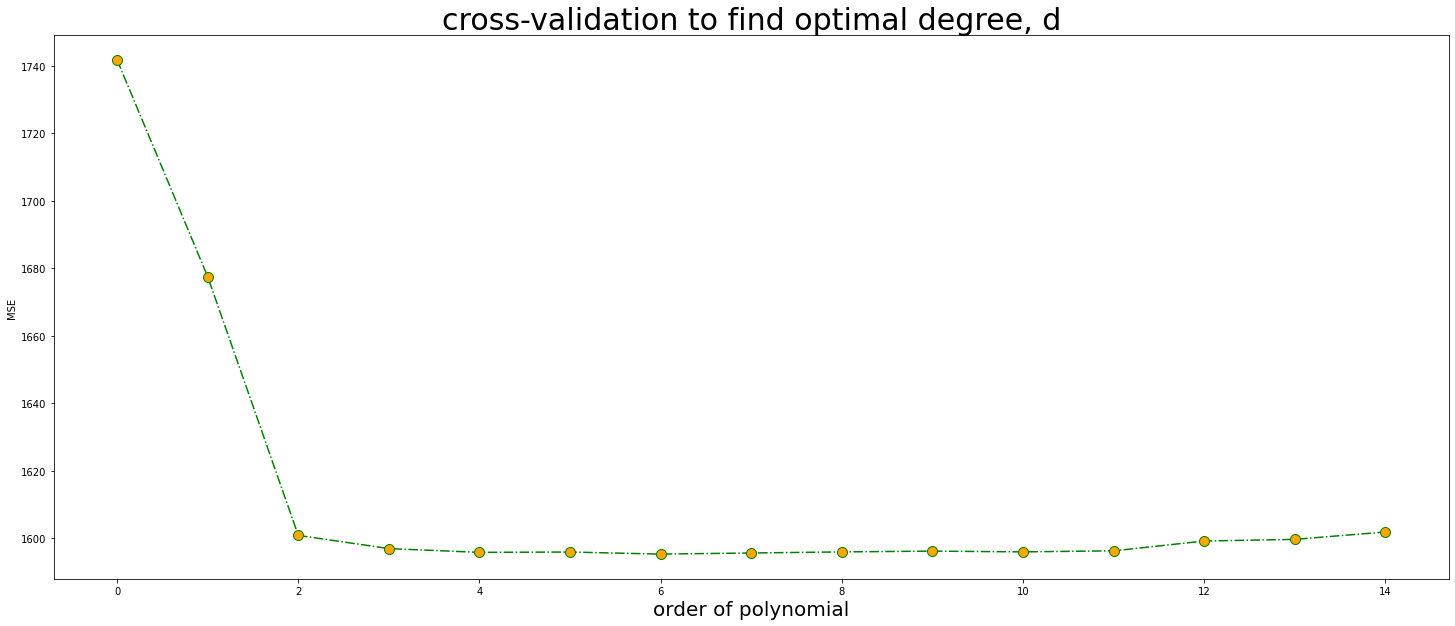

In [11]:
# plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(MSEdf, color='g',  linestyle='-.', marker='o', markerfacecolor='orange', markersize=10)
plt.title('cross-validation to find optimal degree, d', fontsize=30)
plt.xlabel('order of polynomial', fontsize=20)
plt.ylabel('MSE')

**Cross-validation suggests $d$=6 to be give the smallest error and therefore is the optimal degree.**

**Comparing it with $d$=4, which as suggested in R Lab 7.8.1 provides the best fit**

In [13]:
df = pd.concat([y, X, X**2, X**3, X**4, X**5, X**6], axis=1)
df.columns = ['wage', 'age', 'age^2', 'age^3', 'age^4', 'age^5', 'age^6']
lmfit4 = ols("df['wage']~df['age']+df['age^2']+df['age^3']+df['age^4']", data=df).fit()
lmfit5 = ols("df['wage']~df['age']+df['age^2']+df['age^3']+df['age^4']+df['age^5']", data=df).fit()
lmfit6 = ols("df['wage']~df['age']+df['age^2']+df['age^3']+df['age^4']+df['age^5']+df['age^6']", data=df).fit()

In [14]:
anova_table = sm.stats.anova_lm(lmfit4, lmfit5, lmfit6, typ=1)
anova_table.index = anova_table.index+1
anova_table.round(2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,"2,995.0","4,771,604.25",0.0,NaN,NaN,NaN
2,"2,994.0","4,770,321.69",1.0,"1,282.56",0.81,0.37
3,"2,993.0","4,766,389.43",1.0,"3,932.26",2.47,0.12


**ANOVA however suggests that any degree, $d$>4 is not statistically significant (since the $p$-value>5 for $d$>4).**

/opt/homebrew/Caskroom/miniforge/base/envs/ds4b_101p/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'wage')

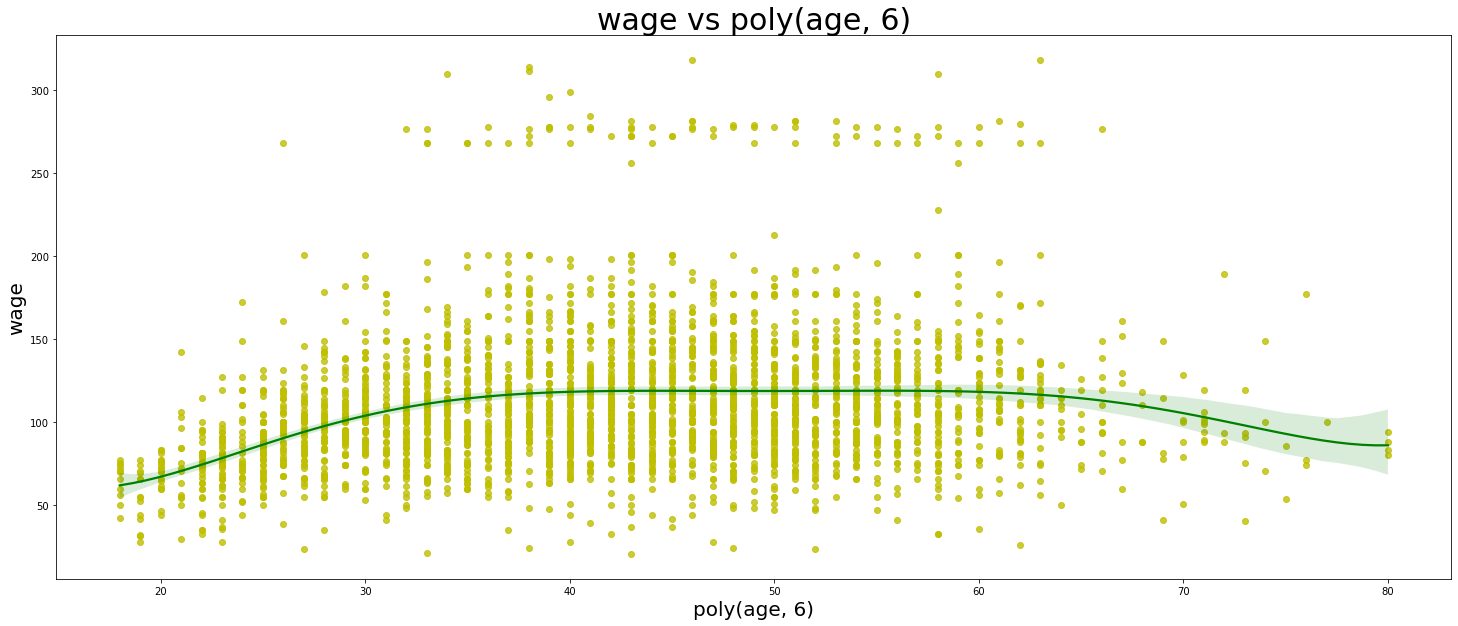

In [15]:
X1 = Wage['age']
X2 = X1**2
X3 = X1**3
X4 = X1**4
X5 = X1**5
X6 = X1**6
plotdf = pd.concat([y, X1, X2, X3, X4, X5, X6], axis=1)
plotdf.columns = ['wage', 'age', 'age^2', 'age^3', 'age^4', 'age^5', 'age^6']
# plt.xkcd()
plt.figure(figsize = (25, 10))
sns.regplot('age', 'wage', data=plotdf, fit_reg=True, ci = 95, color='y', order=6, line_kws={'color':'green'})
plt.title('wage vs poly(age, 6)', fontsize=30)
plt.xlabel('poly(age, 6)', fontsize=20)
plt.ylabel('wage', fontsize=20)

### 6.b. Step function to predict wage using age (through cross-validation to select the optimal number of cuts)

In [16]:
df = pd.concat([y, X], axis=1)
Wage_cut, bins = pd.cut(Wage.age, 4, retbins = True, right = True)
df.head()

,wage,age
SlNo,,
231655,75.0431540173515,18
86582,70.4760196469445,24
161300,130.982177377461,45
155159,154.68529299563,43
11443,75.0431540173515,50


In [17]:
# selecting M, the number of components that give the lowest cross-validation error
n = len(X)
kf10 = KF(n_splits=10, shuffle=True, random_state=42)

MSEdf= pd.DataFrame()
lm = LinearRegression()

# calculating MSE with only the intercept through cross-validation
mse = -1*CVS(lm, np.ones((n,1)), y, cv=kf10, scoring='neg_mean_squared_error').mean()    
MSEdf = MSEdf.append([round(mse, 9)], ignore_index=True)

# calculating MSE for 15 degrees through cross-validation
for i in np.arange(1, 15):
    X = pd.DataFrame(pd.cut(Wage.age, i))
    X = pd.get_dummies(X)
    y = Wage.wage
    mse = -1*CVS(lm, X, y, cv=kf10, scoring='neg_mean_squared_error').mean()
    MSEdf = MSEdf.append([round(mse, 9)])
    
MSEdf.reset_index(drop=True, inplace=True)
MSEdf.columns = ['MSE']
MSEdf

,MSE
0,"1,741.674153197"
1,"1,741.674153197"
2,"1,735.046250236"
3,"1,683.605843356"
4,"1,637.057860957"
5,"1,631.757755881"
6,"1,624.481058342"
7,"1,613.972059147"
8,"1,602.30648001"
9,"1,613.306855884"


In [18]:
# minimum MSEdf
MSEdf.min()

MSE   1,599.98041918
dtype: float64

Text(0, 0.5, 'MSE')

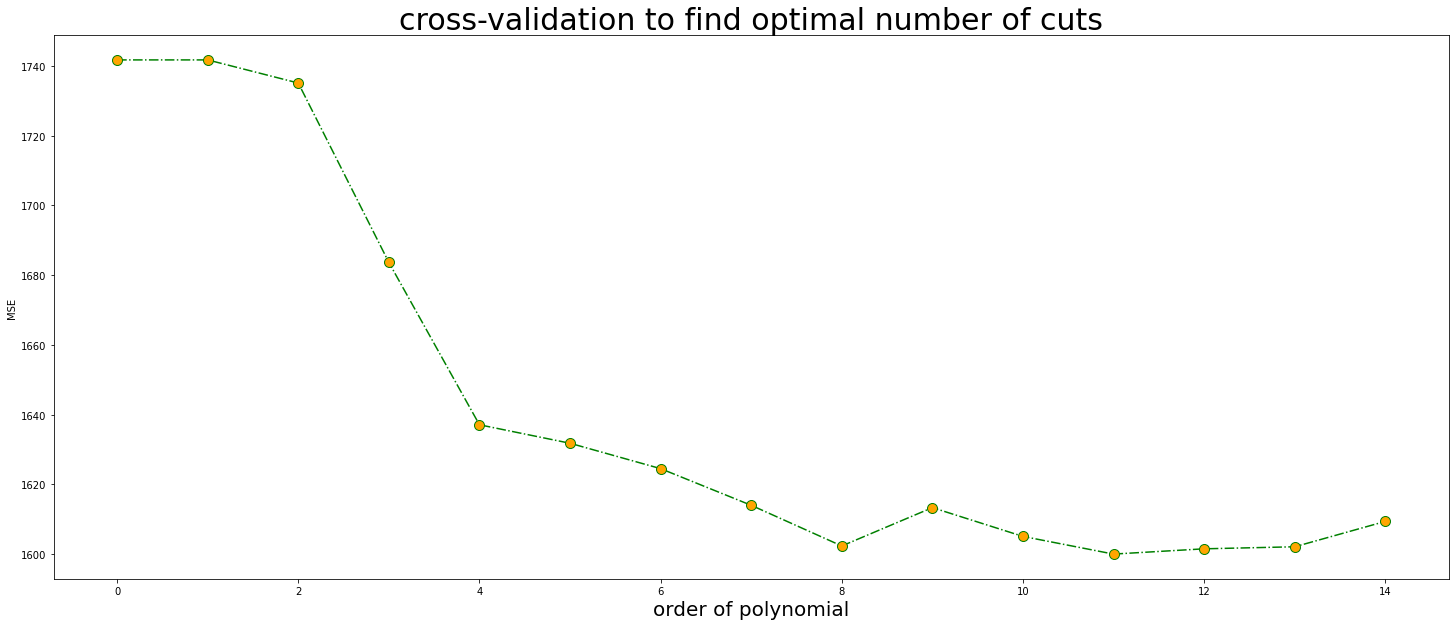

In [19]:
# plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(MSEdf, color='g',  linestyle='-.', marker='o', markerfacecolor='orange', markersize=10)
plt.title('cross-validation to find optimal number of cuts', fontsize=30)
plt.xlabel('order of polynomial', fontsize=20)
plt.ylabel('MSE')

**From the graph, it's clear that the MSE is least at $M$=11.**

**Performing regression**

In [20]:
dfX = pd.DataFrame(pd.cut(Wage.age, 11))
dfX = pd.get_dummies(dfX)
dfX['age'] = Wage.age
dfy = Wage.wage
df_step = pd.concat([dfy, dfX], axis=1)
df_step.head()

,wage,"age_(17.938, 23.636]","age_(23.636, 29.273]","age_(29.273, 34.909]","age_(34.909, 40.545]","age_(40.545, 46.182]","age_(46.182, 51.818]","age_(51.818, 57.455]","age_(57.455, 63.091]","age_(63.091, 68.727]","age_(68.727, 74.364]","age_(74.364, 80.0]",age
SlNo,,,,,,,,,,,,,
231655,75.0431540173515,1,0,0,0,0,0,0,0,0,0,0,18
86582,70.4760196469445,0,1,0,0,0,0,0,0,0,0,0,24
161300,130.982177377461,0,0,0,0,1,0,0,0,0,0,0,45
155159,154.68529299563,0,0,0,0,1,0,0,0,0,0,0,43
11443,75.0431540173515,0,0,0,0,0,1,0,0,0,0,0,50


In [21]:
X = df_step[df_step.columns.difference(['wage', 'age'])]
y = df_step['wage']

lmfitOLS = ols('y~X', data=df_step).fit()
lmfit = LinearRegression().fit(X, y)

In [22]:
lmfitOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     25.87
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           5.97e-52
Time:                        20:55:37   Log-Likelihood:                -15313.
No. Observations:                3000   AIC:                         3.065e+04
Df Residuals:                    2988   BIC:                         3.072e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.683e+13   5.53e+13     -0.486      0.627   -1.35e+14    8.15e+13
X[0]        2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
X[1]        2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
X[2]        2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
X[3]        2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
X[4]        2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
X[5]        2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
X[6]        2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
X[7]        2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
X[8]        2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
X[9]        2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
X[10]       2.683e+13   5.53e+13      0.486      0.627   -8.15e+13    1.35e+14
==============================================================================
Omnibus:                     1084.811   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4843.148
Skew:                           1.704   Prob(JB):                         0.00
Kurtosis:                       8.209   Cond. No.                     2.80e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.36e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

/opt/homebrew/Caskroom/miniforge/base/envs/ds4b_101p/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'wage')

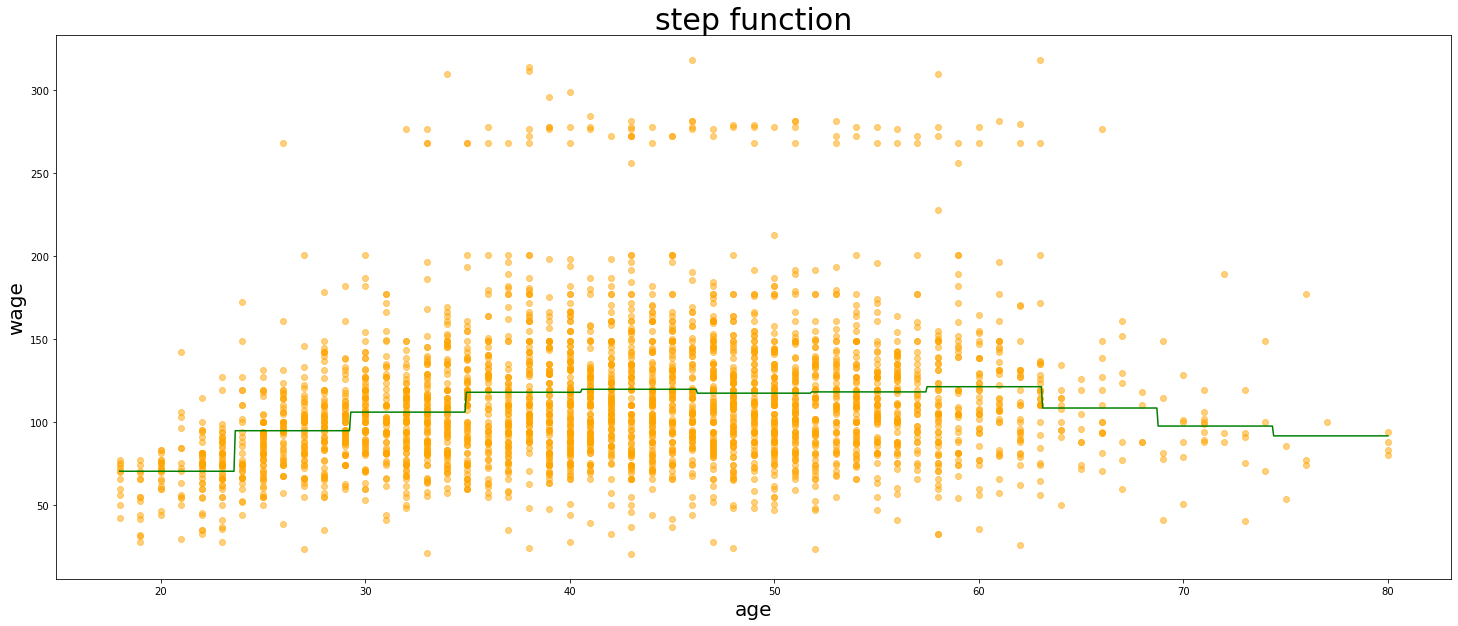

In [24]:
# plt.xkcd()
plt.figure(figsize=(25, 10))
plt.scatter(df_step.age, df_step.wage, color='orange', alpha=.5)
agerange = np.linspace(df_step.age.min(), df_step.age.max(), 1000)
agerange_d = pd.get_dummies(pd.cut(agerange, 11))
predictions = lmfit.predict(agerange_d)
plt.plot(agerange, predictions, color='g')
plt.title('step function', fontsize=30)
plt.xlabel('age', fontsize=20)
plt.ylabel('wage', fontsize=20)